In [66]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [67]:
import xarray as xr
import plot_utils as pu

In [270]:
AIFS_PATH = "/scratch2/mg963/data/ecmwf/ensembles/tp/24/aifs/AIFS_TP_FFX24_NH.nc"
IFS_PATH = "/scratch2/mg963/data/ecmwf/ensembles/tp/24/ifs/IFS_TP_FFX24_NH.nc"
ERA5_PATH = "/scratch2/mg963/data/ecmwf/era5/tp/ERA_NH_TP_aligned.nc"

AIFS_PATH = "/scratch2/mg963/data/ecmwf/ensembles/tp/24/aifs/AIFS_TP_FFX24_SH.nc"
IFS_PATH = "/scratch2/mg963/data/ecmwf/ensembles/tp/24/ifs/IFS_TP_FFX24_TP.nc"
ERA5_PATH = "/scratch2/mg963/data/ecmwf/era5/tp/ERA_SH_TP_aligned.nc"

In [271]:
IFS = xr.open_dataarray(IFS_PATH)

In [272]:
IFS.isel(time=72, number=18).values

array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]],
      shape=(187, 1440), dtype=float32)

In [232]:
# pu.plot_ensemble_maps(filepath=PATH, time='2025-07-30',
#                    binary=True, era5_filepath=ERA5_PATH, 
#                    ncols=7, nrows=7)

In [233]:
# plot_mixed_ensemble_maps(aifs_filepath=AIFS_PATH,
#                          ifs_filepath=IFS_PATH, 
#                          era5_filepath=ERA5_PATH,
#                          time='2025-07-30',
#                          binary=True,
#                          ncols=7, nrows=7)

In [234]:
# pu.plot_ensemble_differences(aifs_filepath=AIFS_PATH,
#                          ifs_filepath=IFS_PATH, 
#                          era5_filepath=ERA5_PATH,
#                          time='2025-07-30',
#                          # binary=True,
#                          ncols=7, nrows=7)

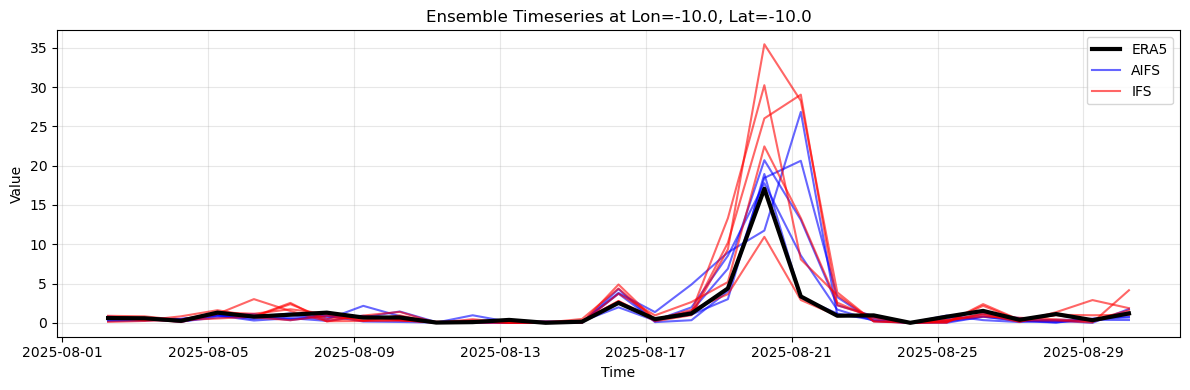

In [235]:
pu.plot_ensemble_timeseries(aifs_filepath=AIFS_PATH, 
                            ifs_filepath=IFS_PATH, 
                            era5_filepath=ERA5_PATH,
                            lat=-10,lon=-10,
                            start_time='2025-08-02',
                            end_time='2025-08-30',
                            figsize=(12,4)
                            )

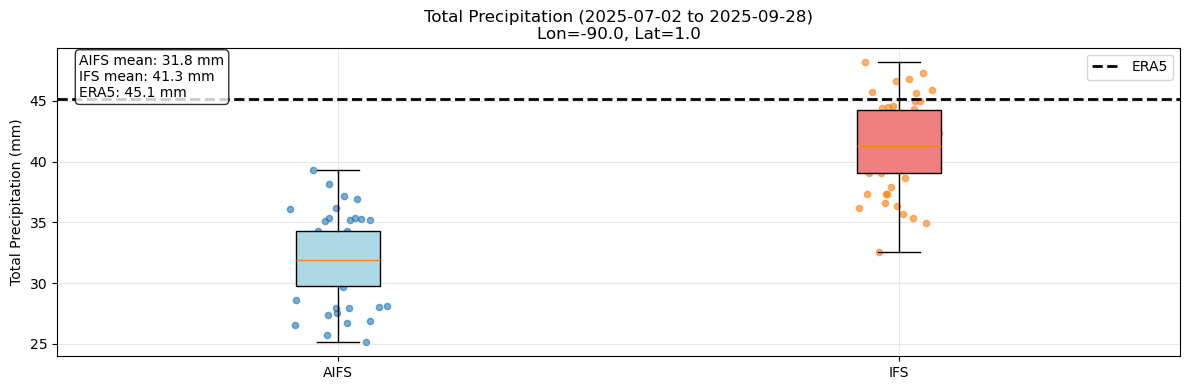

In [243]:
pu.plot_ensemble_precipitation_boxplot(aifs_filepath=AIFS_PATH, 
                            ifs_filepath=IFS_PATH, 
                            era5_filepath=ERA5_PATH,
                            lon=-90,
                            lat=1,
                            start_time='2025-07-02',
                            end_time='2025-09-28',
                            figsize=(12,4)
                            )

In [84]:
import numpy as np

def crps_fair(forecast: xr.DataArray, obs: xr.DataArray, member_dim="member"):
    """
    forecast: DataArray with a member dimension (…, member)
    obs     : DataArray broadcastable to forecast without the member dim (…)
    returns : CRPS_fair with the member dim removed
    """
    M = forecast.sizes[member_dim]
    # term1 = mean |X - y|
    term1 = (np.abs(forecast - obs)).mean(dim=member_dim)

    # term2 = 0.5 * mean_{i≠j} |X - X'|
    def _pairwise_mean_offdiag(a):
        # a: (..., M)
        # pairwise |a_i - a_j|
        diff = np.abs(a[..., None] - a[..., None, :])  # (..., M, M)
        # sum over i,j; diagonal is zero so no need to subtract explicitly
        s = diff.sum(axis=(-2, -1))
        denom = M * (M - 1)
        # handle M=1 safely
        return np.where(denom > 0, 0.5 * s / denom, 0.0)

    term2 = xr.apply_ufunc(
        _pairwise_mean_offdiag, forecast,
        input_core_dims=[[member_dim]],
        output_core_dims=[[]],
        vectorize=True,
        dask="parallelized",
        output_dtypes=[forecast.dtype],
        dask_gufunc_kwargs = {'allow_rechunk':True}
    )

    return term1 - term2

In [353]:
PATH_AIFS = "/scratch2/mg963/data/ecmwf/ensembles/tp/24/aifs/AIFS_NH_TP_7day.nc"
PATH_IFS = "/scratch2//mg963/data/ecmwf/ensembles/tp/24/ifs/IFS_NH_TP_7day.nc"
PATH_ERA = "/scratch2//mg963/data/ecmwf/era5/tp/ERA[BERA_NH_TP_aligned_7day.nc"

AIFS = xr.open_dataarray(PATH_AIFS).isel(time=0)
IFS = xr.open_dataarray(PATH_IFS).isel(time=0)
ERA = xr.open_dataarray(PATH_ERA).isel(time=0)

In [336]:
AIFS.isel(longitude=1, latitude=1).sum().values, IFS.isel(longitude=1, latitude=1).sum().values, ERA.isel(longitude=1, latitude=1).sum().values*50

(array(164.66992, dtype=float32),
 array(219.23828, dtype=float32),
 np.float32(176.69202))

In [337]:
AIFS_CRPS_90 = crps_fair(forecast=AIFS, obs=ERA, member_dim="number")

In [338]:
IFS_CRPS_90 = crps_fair(forecast=IFS, obs=ERA, member_dim="number")

In [339]:
AIFS_CRPS_90.mean().values, IFS_CRPS_90.mean().values

(array(2.4707932, dtype=float32), array(2.5617251, dtype=float32))

In [348]:
AIFS_var = AIFS.var(dim='number')
IFS_var = IFS.var(dim='number')

In [354]:
AIFS

<xarray.DataArray (number: 50, latitude: 267, longitude: 1440)> Size: 77MB
[19224000 values with dtype=float32]
Coordinates:
  * number     (number) int64 400B 1 2 3 4 5 6 7 8 9 ... 43 44 45 46 47 48 49 50
  * latitude   (latitude) float64 2kB 90.0 89.75 89.5 89.25 ... 24.0 23.75 23.5
  * longitude  (longitude) float64 12kB -180.0 -179.8 -179.5 ... 179.5 179.8
    time       datetime64[ns] 8B 2025-07-02T06:00:00
Attributes: (12/34)
    GRIB_paramId:                             228228
    GRIB_dataType:                            pf
    GRIB_numberOfPoints:                      1038240
    GRIB_typeOfLevel:                         surface
    GRIB_stepUnits:                           1
    GRIB_stepType:                            accum
    ...                                       ...
    long_name:                                Total Precipitation
    units:                                    kg m**-2
    standard_name:                            unknown
    aggregation:                              7-day totals
    original_time_steps:                      90
    aggregated_time_steps:                    12

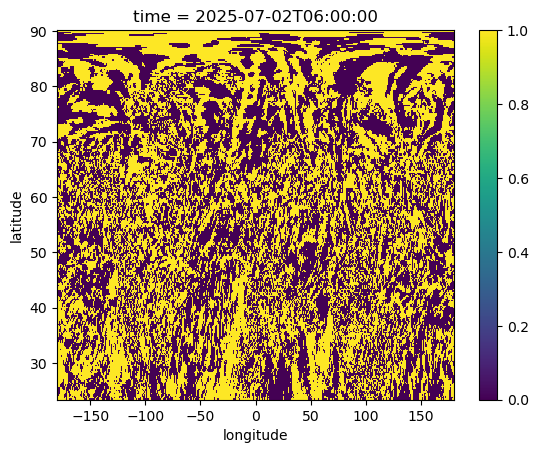

In [340]:
# positive numbers indicate lower IFS CRPS than AIFS CRPS
((AIFS_CRPS_90 - IFS_CRPS_90)>0).plot()

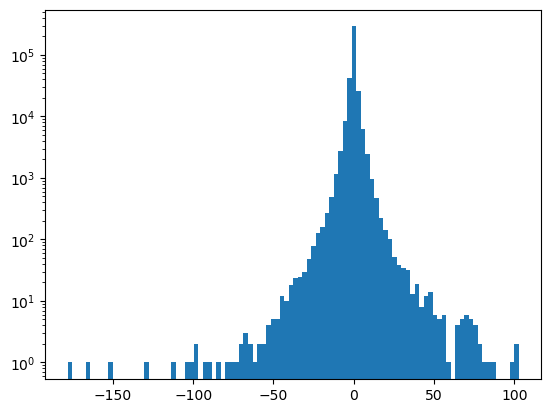

In [341]:
plt.hist((AIFS_CRPS_90 - IFS_CRPS_90).values.flatten(), log=True, bins=100);

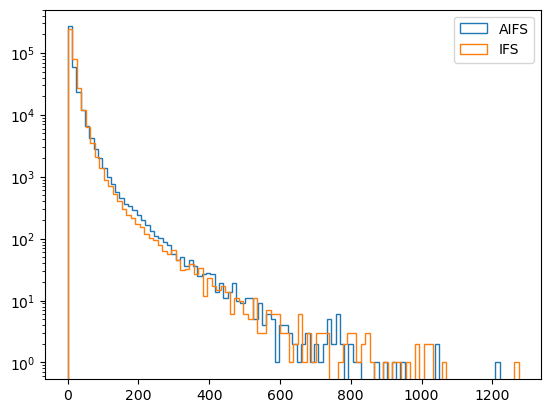

In [321]:
plt.hist(AIFS_CRPS_90.values.flatten(), bins=100, label='AIFS', log=True, histtype='step');
plt.hist(IFS_CRPS_90.values.flatten(),bins=100, label='IFS', log=True, histtype='step');
plt.legend()
plt.show()